You should add the following libraries to the amlfall24 environment
- pip install pyarrow datasets huggingface_hub transformers

In [1]:
pip install pyarrow datasets huggingface_hub transformers

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import pandas as pd
from pathlib import Path
from PIL import Image
from datasets import load_dataset, DownloadMode
import tensorflow as tf

# Define the location where you wish to save the dataset 
filepath = r'C:\Users\COChr\Desktop\Data'

# Define the destination path
destination_path = str(Path(filepath))

# Create the destination directory if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

# Load the entire dataset
dataset = load_dataset(
    "ahmed-ai/skin-lesions-classification-dataset", 
    cache_dir=destination_path,
    download_mode=DownloadMode.REUSE_DATASET_IF_EXISTS 
)

# Alternatively, load a specific split of the dataset
# dataset = load_dataset(
#     "ahmed-ai/skin-lesions-classification-dataset",
#     split={
#         'train': 'train[:50%]',
#         'validation': 'validation[:50%]',
#         'test': 'test[:50%]'
#     },
#     cache_dir=destination_path,
#     download_mode=DownloadMode.REUSE_DATASET_IF_EXISTS 
# )

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

In [3]:
from PIL import Image

# Set image target height and width: That is entirely your choice...below is just an example
TARGET_HEIGHT = 224
TARGET_WIDTH = 224

# Resize function in case it is needed
def resize_images(example):
    # Resize the image using PIL
    example['image'] = example['image'].resize((TARGET_WIDTH, TARGET_HEIGHT), Image.BICUBIC)
    return example

# Apply the resizing function
resized_dataset = dataset.map(resize_images)

In [4]:
# Split the dataset into training, validation, and test sets
df_train = dataset['train']
df_train_rs = resized_dataset['train']
df_validation = dataset['validation']
df_validation_rs = resized_dataset['validation']
df_test = dataset['test']
df_test_rs = resized_dataset['test']

# Display the sizes of the splits
print(f"Train dataset size: {len(df_train_rs)}")
print(f"Validation dataset size: {len(df_validation_rs)}")
print(f"Test dataset size: {len(df_test)}")

# Get the column names
print("\nColumn names in the training data:")
print(resized_dataset['train'].column_names)

Train dataset size: 29322
Validation dataset size: 3660
Test dataset size: 3674

Column names in the training data:
['image', 'label']


In [5]:
# computing the number of categories in the label column
num_categories = len(set(df_train_rs['label']))
print(f"Number of categories in label: {num_categories}")

Number of categories in label: 14


In [6]:
import numpy as np
# computing the shape of the images
image_shape = np.array(df_train_rs[0]["image"]).shape
print(f"Shape of each image in df_train_rs: {image_shape}")

Shape of each image in df_train_rs: (224, 224, 3)


In [7]:
# computing the number of images in the training set
num_images = len(df_train_rs)
print(f"Number of images in the training set: {num_images}")

Number of images in the training set: 29322


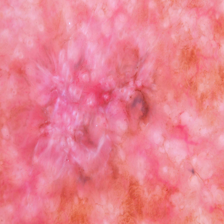

In [8]:
# plotting the first image in the training set
df_train_rs[0]["image"]

In [9]:
# Create a TensorFlow dataset
tf_train = df_train_rs.to_tf_dataset(
            columns='image',
            label_cols='label',
            batch_size=32,
            shuffle=True,
            drop_remainder=True
            )
tf_validation = df_validation_rs.to_tf_dataset(
            columns='image',
            label_cols='label',
            batch_size=32,
            shuffle=True,
            drop_remainder=True
            )
tf_test = df_test_rs.to_tf_dataset(
            columns='image',
            label_cols='label',
            batch_size=128,
            shuffle=True
            )

HINT: Maybe a good idea to save the curated tf.data datasets at this point for easier access later

In [ ]:
tf.data.experimental.save(tf_train, r'C:\Users\COChr\Desktop\Data\train')
tf.data.experimental.save(tf_validation, r'C:\Users\COChr\Desktop\Data\validation')
tf.data.experimental.save(tf_test, r'C:\Users\COChr\Desktop\Data\test')

# Load the saved datasets
tf_train = tf.data.experimental.load(r'C:\Users\COChr\Desktop\Data\train')
tf_validation = tf.data.experimental.load(r'C:\Users\COChr\Desktop\Data\validation')
tf_test = tf.data.experimental.load(r'C:\Users\COChr\Desktop\Data\test')


In [10]:
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset_224 = tf_train.map(preprocess_image)
validation_dataset_224 = tf_validation.map(preprocess_image)
test_dataset_224 = tf_test.map(preprocess_image)

## Plotting the loaded images with labels

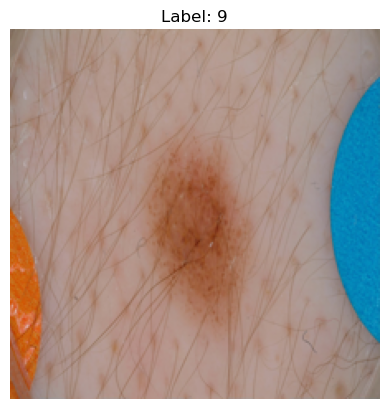

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Example: Assuming `dataset` is your tf.data.Dataset object
# It should yield image-label pairs

for image, label in train_dataset_224.take(1):
    #Check image type and normalize accordingly
    if image.dtype.is_floating:
        image = tf.clip_by_value(image, 0.0, 1.0)
    elif image.dtype.is_integer:
        image = tf.clip_by_value(image, 0, 255)

    # Convert to numpy for display
    image = image.numpy()

    # Plot the image
    plt.imshow(image[0])  # Assuming the dataset has batches
    plt.title(f"Label: {label[0].numpy()}")
    plt.axis("off")
    plt.show()

## Example: Based on the data train a very simply CNN model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

In [ ]:
def first_ccn_model():
    input_img = Input(shape=(TARGET_HEIGHT,TARGET_WIDTH,3))

    x = Conv2D(16, (3, 3), padding='valid', activation='relu')(input_img)
    x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    y = Dense(14, activation='softmax')(x)

    model = Model(inputs=input_img, outputs=y)
    return model

sgd_opt = SGD(learning_rate=0.01, momentum=0.9, decay=0.0, nesterov=True)

model = first_ccn_model()

model.compile(optimizer=sgd_opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(train_dataset_224,
                 validation_data=validation_dataset_224,
                 epochs=2)

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_dataset_224)
print(f"Test accuracy: {test_acc}")

## Convert tf data to be suitable for shallow learners

In [12]:
import tensorflow as tf
import numpy as np
import hashlib

def is_noisy(image, variance_threshold=0.5):
    """
    Check if an image is noisy based on pixel intensity variance.

    Args:
        image: A single image (grayscale or RGB).
        variance_threshold: Variance threshold. Images with variance above this are considered noisy.

    Returns:
        bool: True if the image is noisy, False otherwise.
    """
    variance = np.var(image.numpy())
    return variance > variance_threshold

def hash_image(image):
    """
    Hash an image using SHA-256 for duplicate detection.

    Args:
        image: A single image as a numpy array.

    Returns:
        str: The hash of the image.
    """
    image_bytes = image.tobytes()
    return hashlib.sha256(image_bytes).hexdigest()

def process_dataset_with_noise_filter(dataset, target_size=(96, 96), variance_threshold=0.5):
    """
    Process a TensorFlow dataset into scaled images and labels suitable for ML models.
    Filter out noisy images and remove duplicates.

    Args:
        dataset: tf.data.Dataset containing image-label pairs.
        target_size: tuple of (height, width) for image resizing.
        variance_threshold: Variance threshold for filtering noisy images.

    Returns:
        processed_images: numpy array of flattened, scaled images.
        labels: numpy array of labels.
        removed_noisy_count: Number of noisy images removed.
        removed_duplicate_count: Number of duplicate images removed.
    """
    images_list = []
    labels_list = []
    removed_noisy_count = 0  # Track the number of noisy images removed
    removed_duplicate_count = 0  # Track the number of duplicate images removed
    image_hashes = set()  # Set to store unique image hashes

    for image, label in dataset.unbatch():
        # Convert to grayscale and resize
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.resize(image, target_size)

        # Check if the image is noisy
        if is_noisy(image, variance_threshold):
            removed_noisy_count += 1  # Count the removed noisy image
            continue  # Skip this image if it is noisy

        # Normalize to [0, 1]
        image = image.numpy().astype('float32') / 255.0
        # Ensure correct shape
        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=-1)

        # Check for duplicates
        image_hash = hash_image(image)
        if image_hash in image_hashes:
            removed_duplicate_count += 1  # Count the duplicate
            continue  # Skip this image if it is a duplicate
        image_hashes.add(image_hash)  # Add hash to the set of seen images

        # Flatten image and add to the list
        images_list.append(image.reshape(-1))
        labels_list.append(label)

    # Stack and convert to numpy arrays
    processed_images = np.vstack(images_list)
    labels = np.array(labels_list)

    return processed_images, labels, removed_noisy_count, removed_duplicate_count

# Example usage
print("Processing train dataset with noise filtering and duplicate removal...")
train_dataset_32_numpy, train_labels_numpy, train_noisy_removed, train_duplicates_removed = process_dataset_with_noise_filter(
    train_dataset_224.take(5000), target_size=(32, 32), variance_threshold=0.5
)
print(f"Number of noisy images removed from training set: {train_noisy_removed}")
print(f"Number of duplicate images removed from training set: {train_duplicates_removed}")

print("Processing validation dataset with noise filtering and duplicate removal...")
validation_dataset_32_numpy, validation_labels_numpy, validation_noisy_removed, validation_duplicates_removed = process_dataset_with_noise_filter(
    validation_dataset_224.take(500), target_size=(32, 32), variance_threshold=0.5
)
print(f"Number of noisy images removed from validation set: {validation_noisy_removed}")
print(f"Number of duplicate images removed from validation set: {validation_duplicates_removed}")

print("Processing test dataset with noise filtering and duplicate removal...")
test_dataset_32_numpy, test_labels_numpy, test_noisy_removed, test_duplicates_removed = process_dataset_with_noise_filter(
    test_dataset_224.take(500), target_size=(32, 32), variance_threshold=0.5
)
print(f"Number of noisy images removed from test set: {test_noisy_removed}")
print(f"Number of duplicate images removed from test set: {test_duplicates_removed}")

# Total removed images
total_noisy_removed = train_noisy_removed + validation_noisy_removed + test_noisy_removed
total_duplicates_removed = train_duplicates_removed + validation_duplicates_removed + test_duplicates_removed

print(f"\nTotal number of noisy images removed across all datasets: {total_noisy_removed}")
print(f"Total number of duplicate images removed across all datasets: {total_duplicates_removed}")


Processing train dataset with noise filtering and duplicate removal...
Number of noisy images removed from training set: 0
Number of duplicate images removed from training set: 659
Processing validation dataset with noise filtering and duplicate removal...
Number of noisy images removed from validation set: 0
Number of duplicate images removed from validation set: 9
Processing test dataset with noise filtering and duplicate removal...
Number of noisy images removed from test set: 0
Number of duplicate images removed from test set: 11

Total number of noisy images removed across all datasets: 0
Total number of duplicate images removed across all datasets: 679


In [13]:
# Print dimensions
print("\nDataset Dimensions:")
print("-" * 50)
print(f"Training Data:")
print(f"Images: {train_dataset_32_numpy.shape} (samples, features)")
print(f"Labels: {train_labels_numpy.shape}")
print(f"\nValidation Data:")
print(f"Images: {validation_dataset_32_numpy.shape} (samples, features)")
print(f"Labels: {validation_labels_numpy.shape}")
print(f"\nTest Data:")
print(f"Images: {test_dataset_32_numpy.shape} (samples, features)")
print(f"Labels: {test_labels_numpy.shape}")

# Print feature information
n_features = train_dataset_32_numpy.shape[1]
print(f"\nNumber of features per image: {n_features} (32x32x1 flattened)")


Dataset Dimensions:
--------------------------------------------------
Training Data:
Images: (28653, 1024) (samples, features)
Labels: (28653,)

Validation Data:
Images: (3639, 1024) (samples, features)
Labels: (3639,)

Test Data:
Images: (3663, 1024) (samples, features)
Labels: (3663,)

Number of features per image: 1024 (32x32x1 flattened)


## Hint: Save the data in its new format for easier/faster access later

In [ ]:
import os
import numpy as np
import pandas as pd

# Specify the local directory
save_dir = r'C:\Users\COChr\Desktop\Data\SVM'  # Replace with your desired path

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)


np.save(os.path.join(save_dir, 'train_images.npy'), train_dataset_32_numpy)
print("Saved train_images.npy")
np.save(os.path.join(save_dir, 'train_labels.npy'), train_labels_numpy)
print("Saved train_labels.npy")

np.save(os.path.join(save_dir, 'validation_images.npy'), validation_dataset_32_numpy)
print("Saved validation_images.npy")
np.save(os.path.join(save_dir, 'validation_labels.npy'), validation_labels_numpy)
print("Saved validation_labels.npy")

np.save(os.path.join(save_dir, 'test_images.npy'), test_dataset_32_numpy)
print("Saved test_images.npy")
np.save(os.path.join(save_dir, 'test_labels.npy'), test_labels_numpy)
print("Saved test_labels.npy")


Saved train_images.npy
Saved train_labels.npy
Saved validation_images.npy
Saved validation_labels.npy
Saved test_images.npy
Saved test_labels.npy


## Example: Using the data for training a support vector machine

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Create SVM classifier
svm_classifier = SVC(kernel='rbf', random_state=42, )

# Train the model on training data
print("Training SVM classifier...")
svm_classifier.fit(train_dataset_32_numpy, train_labels_numpy)

# Make predictions on all splits
print("\nMaking predictions...")
train_predictions = svm_classifier.predict(train_dataset_32_numpy)
val_predictions = svm_classifier.predict(validation_dataset_32_numpy)
test_predictions = svm_classifier.predict(test_dataset_32_numpy)

# Evaluate performance on all splits
print("\nPerformance Metrics:")
print("-" * 50)
print("Training Set:")
print(f"Accuracy: {accuracy_score(train_labels_numpy, train_predictions):.4f}")
print(classification_report(train_labels_numpy, train_predictions))

print("\nValidation Set:")
print(f"Accuracy: {accuracy_score(validation_labels_numpy, val_predictions):.4f}")
print(classification_report(validation_labels_numpy, val_predictions))

print("\nTest Set:")
print(f"Accuracy: {accuracy_score(test_labels_numpy, test_predictions):.4f}")
print(classification_report(test_labels_numpy, test_predictions))

Training SVM classifier...

Making predictions...

Performance Metrics:
--------------------------------------------------
Training Set:
Accuracy: 0.6419
              precision    recall  f1-score   support

           0       0.60      0.00      0.01       693
           1       0.43      0.44      0.44      2657
           2       0.84      0.03      0.06      2097
           3       0.93      0.30      0.45       900
           4       0.98      0.53      0.68       791
           5       0.00      0.00      0.00       191
           6       0.91      0.83      0.87      1931
           7       0.96      0.75      0.84      1368
           8       0.93      0.53      0.68       660
           9       0.60      0.93      0.73     10297
          10       0.73      0.32      0.45      3615
          11       0.63      0.92      0.75      3408
          12       0.00      0.00      0.00       502
          13       0.00      0.00      0.00       202

    accuracy                      

c:\Users\COChr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\COChr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\COChr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\COChr\anaconda3\Lib\site-packag

PCA 

Original number of features: 1024
Reduced number of features: 588


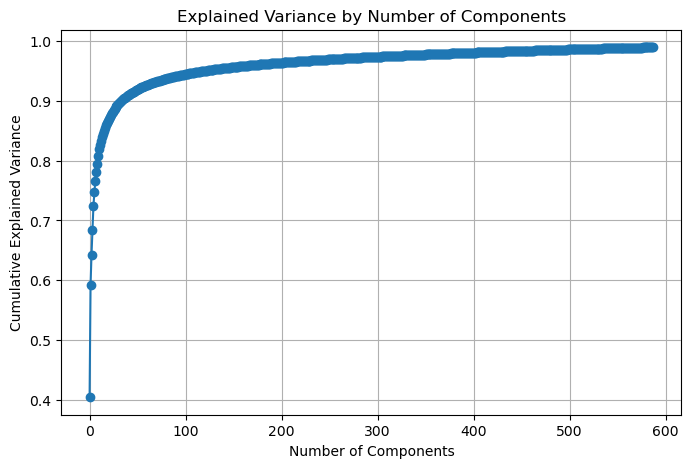

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Standardize the data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_dataset_32_numpy)  
validation_data_scaled = scaler.transform(validation_dataset_32_numpy)  
test_data_scaled = scaler.transform(test_dataset_32_numpy)  

# Apply PCA to retain 95% variance
pca = PCA(n_components=0.99)  # Retain 95% of the variance
train_data_pca = pca.fit_transform(train_data_scaled)
validation_data_pca = pca.transform(validation_data_scaled)
test_data_pca = pca.transform(test_data_scaled)

# Print the reduced dimensionality
print(f"Original number of features: {train_dataset_32_numpy.shape[1]}")
print(f"Reduced number of features: {train_data_pca.shape[1]}")

# Plot explained variance ratio
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Explained Variance by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()


BASIC SVM MODEL

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Create SVM classifier
svm_classifier = SVC(kernel='rbf', random_state=42)

# Train the model on PCA-transformed training data
print("Training SVM classifier on PCA-transformed data...")
svm_classifier.fit(train_data_pca, train_labels_numpy)  

# Make predictions on PCA-transformed datasets
print("\nMaking predictions...")
train_predictions = svm_classifier.predict(train_data_pca)  
val_predictions = svm_classifier.predict(validation_data_pca)  
test_predictions = svm_classifier.predict(test_data_pca) 

# Evaluate performance on all splits
print("\nPerformance Metrics:")
print("-" * 50)

# Training Set Performance
print("Training Set:")
print(f"Accuracy: {accuracy_score(train_labels_numpy, train_predictions):.4f}")
print(classification_report(train_labels_numpy, train_predictions))

# Validation Set Performance
print("\nValidation Set:")
print(f"Accuracy: {accuracy_score(validation_labels_numpy, val_predictions):.4f}")
print(classification_report(validation_labels_numpy, val_predictions))

# Test Set Performance
print("\nTest Set:")
print(f"Accuracy: {accuracy_score(test_labels_numpy, test_predictions):.4f}")
print(classification_report(test_labels_numpy, test_predictions))


GRID SEARCH FOR SVM HYPER TUNING

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Subset the dataset (use 20% of the training data for faster computation)
subset_size = 0.2
train_data_subset, _, train_labels_subset, _ = train_test_split(
    train_data_pca, train_labels_numpy, test_size=(1 - subset_size), stratify=train_labels_numpy, random_state=42
)

kernels = ["linear", "poly", "rbf"]
Cs = [0.1, 1, 5]
decision_functions = ["ovr", "ovo"]
best_accuracy = 0
best_params = {}

# Perform the grid search on the subset of PCA-reduced data
for kernel in kernels:
    for C in Cs:
        for decision_function in decision_functions:
            # SVM model
            svm_model = SVC(kernel=kernel, C=C, decision_function_shape=decision_function)
            svm_model.fit(train_data_subset, train_labels_subset)  

            # Validate on PCA-reduced validation data
            val_predictions = svm_model.predict(validation_data_pca)
            accuracy = accuracy_score(validation_labels_numpy, val_predictions)

            # Update best parameters if accuracy improves
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'kernel': kernel, 'C': C, 'decision_function_shape': decision_function}

# Print the best parameters and accuracy
print(f"Best Parameters: {best_params} with accuracy: {best_accuracy:.4f}")
 # OUTPUT: Best Parameters: {'kernel': 'rbf', 'C': 5, 'decision_function_shape': 'ovr'} with accuracy: 0.5587

TRAINING MODEL WITH THE BEST PARAMETERS

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Best parameters obtained from grid search
best_params = {
    'kernel': 'rbf',  
    'C': 5,           
    'decision_function_shape': 'ovr'  
}

# Create SVM classifier with the best parameters
svm_classifier = SVC(
    kernel=best_params['kernel'],
    C=best_params['C'],
    decision_function_shape=best_params['decision_function_shape'],
    random_state=42
)

# Train the model on scaled training data
print("Training SVM classifier with the best parameters on scaled data...")
svm_classifier.fit(train_data_scaled, train_labels_numpy)  

# Make predictions on scaled datasets
print("\nMaking predictions...")
train_predictions = svm_classifier.predict(train_data_scaled)  
val_predictions = svm_classifier.predict(validation_data_scaled)  
test_predictions = svm_classifier.predict(test_data_scaled)  

# Evaluate performance on all splits
print("\nPerformance Metrics:")
print("-" * 50)

# Training Set Performance
print("Training Set:")
print(f"Accuracy: {accuracy_score(train_labels_numpy, train_predictions):.4f}")
print(classification_report(train_labels_numpy, train_predictions))

# Validation Set Performance
print("\nValidation Set:")
print(f"Accuracy: {accuracy_score(validation_labels_numpy, val_predictions):.4f}")
print(classification_report(validation_labels_numpy, val_predictions))

# Test Set Performance
print("\nTest Set:")
print(f"Accuracy: {accuracy_score(test_labels_numpy, test_predictions):.4f}")
print(classification_report(test_labels_numpy, test_predictions))


RANDOM FOREST BASIC MODLE

In [14]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# --- Random Forest Model ---
print("\nTraining Random Forest Model...")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(train_data_scaled, train_labels_numpy)  

# Make predictions for Random Forest
rf_train_predictions = rf_model.predict(train_data_scaled)
rf_val_predictions = rf_model.predict(validation_data_scaled)
rf_test_predictions = rf_model.predict(test_data_scaled)

# Evaluate Random Forest Model
print("\nRandom Forest Performance Metrics:")
print("-" * 50)
print("Training Set:")
print(f"Accuracy: {accuracy_score(train_labels_numpy, rf_train_predictions):.4f}")
print(classification_report(train_labels_numpy, rf_train_predictions))

print("\nValidation Set:")
print(f"Accuracy: {accuracy_score(validation_labels_numpy, rf_val_predictions):.4f}")
print(classification_report(validation_labels_numpy, rf_val_predictions))

print("\nTest Set:")
print(f"Accuracy: {accuracy_score(test_labels_numpy, rf_test_predictions):.4f}")
print(classification_report(test_labels_numpy, rf_test_predictions))


Training Random Forest Model...

Random Forest Performance Metrics:
--------------------------------------------------
Training Set:
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       686
           1       1.00      1.00      1.00      2654
           2       1.00      1.00      1.00      2087
           3       1.00      1.00      1.00       832
           4       1.00      1.00      1.00       744
           5       1.00      1.00      1.00       191
           6       1.00      1.00      1.00      1812
           7       1.00      1.00      1.00      1283
           8       1.00      1.00      1.00       613
           9       1.00      1.00      1.00     10288
          10       1.00      1.00      1.00      3609
          11       1.00      1.00      1.00      3151
          12       1.00      1.00      1.00       502
          13       1.00      1.00      1.00       202

    accuracy                         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Random forrest grid Search

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the parameter grid with fewer combinations
param_dist = {
    "n_estimators": [100, 200, 300],  
    "max_depth": [15, 25, 35],  
    "min_samples_split": [3, 5, 7],  
    "min_samples_leaf": [1, 2, 3]
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42, warm_start=True, n_jobs=-1)

# Use Randomized Search instead of Grid Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,  
    cv=3, 
    scoring="accuracy",
    verbose=2,
)

# Fit the Randomized Search on training data
random_search.fit(train_data_scaled, train_labels_numpy)

# Print best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=10, min_samples_leaf=3, min_samples_split=7, n_estimators=150; total time=  24.5s
[CV] END max_depth=10, min_samples_leaf=3, min_samples_split=7, n_estimators=150; total time=  26.3s
[CV] END max_depth=10, min_samples_leaf=3, min_samples_split=7, n_estimators=150; total time=  30.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  15.9s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  16.6s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  11.9s
[CV] END max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=  23.8s
[CV] END max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time= 1.7min
[CV] END max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=  23.6s
[CV] END max_depth=20, min_sam

NEW BEST TREE

In [26]:
best_params = {
    "n_estimators": 300,  # Increase the number of trees for stability
    "max_depth": 25,  # Allow deeper trees (reduce underfitting)
    "min_samples_split": 3,  # Allow splitting slightly more
    "min_samples_leaf": 2,  # Keep leaf nodes small but not too small
    "random_state": 42,
    "class_weight": "balanced_subsample"  # Adjust for potential class imbalance
}

# Train a better Random Forest model
rf_model = RandomForestClassifier(**best_params)
rf_model.fit(train_data_scaled, train_labels_numpy)

# Predictions
rf_train_predictions = rf_model.predict(train_data_scaled)
rf_val_predictions = rf_model.predict(validation_data_scaled)
rf_test_predictions = rf_model.predict(test_data_scaled)

# Evaluate Performance
print("\n Random Forest Performance Metrics:")
print("-" * 50)

# Training Set
print(" Training Set:")
print(f"Accuracy: {accuracy_score(train_labels_numpy, rf_train_predictions):.4f}")
print(classification_report(train_labels_numpy, rf_train_predictions))

# Validation Set
print("\n Validation Set:")
print(f"Accuracy: {accuracy_score(validation_labels_numpy, rf_val_predictions):.4f}")
print(classification_report(validation_labels_numpy, rf_val_predictions))

# Test Set
print("\n Test Set:")
print(f"Accuracy: {accuracy_score(test_labels_numpy, rf_test_predictions):.4f}")
print(classification_report(test_labels_numpy, rf_test_predictions))



🔍 Random Forest Performance Metrics:
--------------------------------------------------
🏋️ Training Set:
Accuracy: 0.9971
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       685
           1       0.98      1.00      0.99      2653
           2       1.00      1.00      1.00      2088
           3       1.00      1.00      1.00       832
           4       1.00      1.00      1.00       742
           5       1.00      1.00      1.00       191
           6       1.00      1.00      1.00      1813
           7       1.00      1.00      1.00      1282
           8       1.00      1.00      1.00       613
           9       1.00      0.99      1.00     10288
          10       1.00      1.00      1.00      3611
          11       0.99      1.00      1.00      3152
          12       1.00      1.00      1.00       502
          13       1.00      1.00      1.00       201

    accuracy                           1.00     28653
   macro av

c:\Users\COChr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\COChr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\COChr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\COChr\anaconda3\Lib\site-packag

Basic xgboost Model

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report

# Initialize and configure the XGBoost model
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",  # Multi-class classification
    random_state=42            # Ensure reproducibility
)

# Train the model on scaled training data
xgb_model.fit(train_data_scaled, train_labels_numpy)

# Make predictions on the test set
xgb_predictions = xgb_model.predict(test_data_scaled)

# Evaluate the model performance on the test set
print("\nXGBoost Model Performance:")
print(classification_report(test_labels_numpy, xgb_predictions))


BASIC LGBM Model

In [ ]:
import lightgbm as lgb
from sklearn.metrics import classification_report

# Initialize and configure the LGBM model
lgb_model = lgb.LGBMClassifier(
    objective="multiclass",  
    random_state=42          
)

# Train the model on scaled training data
lgb_model.fit(train_data_scaled, train_labels_numpy)

# Make predictions on the test set
lgb_predictions = lgb_model.predict(test_data_scaled)

# Evaluate the model performance on the test set
print("\nLightGBM Model Performance:")
print(classification_report(test_labels_numpy, lgb_predictions))


FINDIG THE BEST PARAMETER FOR XGBOOST

In [18]:
import optuna
import xgboost as xgb
from sklearn.metrics import accuracy_score

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 0.3),
    }

    # Define the XGBoost model
    model = xgb.XGBClassifier(
        objective="multi:softmax",
        eval_metric="mlogloss",
        tree_method="gpu_hist",  
        random_state=42,
        enable_categorical=False,  
        **params
    )

    # Train the model on scaled training data
    model.fit(
        train_data_scaled, train_labels_numpy,
        eval_set=[(validation_data_scaled, validation_labels_numpy)],  
        verbose=False  
    )

    # Predict on validation data
    preds = model.predict(validation_data_scaled)
    return accuracy_score(validation_labels_numpy, preds)

# Run the Optuna hyperparameter optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Print best parameters
print("\nBest Parameters Found:", study.best_params)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report

# Define the final model using the best parameters found by Optuna
final_model = xgb.XGBClassifier(
    n_estimators=670,
    max_depth=44,
    learning_rate=0.04303725372313019,
    subsample=0.6029115855774464,
    colsample_bytree=0.6000667872069467,
    gamma=0.020130953938987152,
    objective="multi:softmax",
    eval_metric="mlogloss",
    tree_method="gpu_hist",
    enable_categorical=False,
    random_state=42
)

# Train the model on the processed training data
final_model.fit(train_dataset_32_numpy, train_labels_numpy)

# Make predictions on the processed test set
test_preds = final_model.predict(test_dataset_32_numpy)

# Evaluate the model's performance on the test set
print("\nFinal Test Set Performance:")
print(classification_report(test_labels_numpy, test_preds))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:12:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:20:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:20:44] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.



Final Test Set Performance:
              precision    recall  f1-score   support

           0       0.28      0.06      0.09        88
           1       0.46      0.54      0.50       333
           2       0.52      0.13      0.21       262
           3       0.85      0.58      0.69       111
           4       0.89      0.69      0.78        99
           5       0.00      0.00      0.00        25
           6       0.85      0.79      0.82       239
           7       0.85      0.75      0.79       170
           8       0.87      0.57      0.69        81
           9       0.66      0.91      0.77      1288
          10       0.56      0.36      0.44       453
          11       0.69      0.91      0.79       424
          12       0.60      0.05      0.09        64
          13       0.00      0.00      0.00        26

    accuracy                           0.67      3663
   macro avg       0.58      0.45      0.47      3663
weighted avg       0.64      0.67      0.63      36

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Combined STacking method (SVM and XGBoost)

In [16]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split

# Reduce dataset to 50% using train_test_split
train_data_reduced, _, train_labels_reduced, _ = train_test_split(
    train_data_scaled, train_labels_numpy, test_size=0.2, random_state=42, stratify=train_labels_numpy
)

validation_data_reduced, _, validation_labels_reduced, _ = train_test_split(
    validation_data_scaled, validation_labels_numpy, test_size=0.2, random_state=42, stratify=validation_labels_numpy
)

test_data_reduced, _, test_labels_reduced, _ = train_test_split(
    test_data_scaled, test_labels_numpy, test_size=0.2, random_state=42, stratify=test_labels_numpy
)

# Define SVM model with the best parameters
svm_model = SVC(kernel='rbf', C=5, decision_function_shape='ovr', probability=True, random_state=42)

# Best XGBoost parameters (from Optuna)
xgb_best_params = {
    "n_estimators": 670,
    "max_depth": 44,
    "learning_rate": 0.04303725372313019,
    "subsample": 0.6029115855774464,
    "colsample_bytree": 0.6000667872069467,
    "gamma": 0.020130953938987152
}

# Initialize XGBoost model with optimized parameters
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",   
    eval_metric="mlogloss",      
    tree_method="hist",          
    enable_categorical=False,
    random_state=42,
    **xgb_best_params
)

# Meta-model: Logistic Regression
meta_model = LogisticRegression()

# Combine reduced training and validation data for stacking
combined_train_data = np.vstack([train_data_reduced, validation_data_reduced])  
combined_train_labels = np.hstack([train_labels_reduced, validation_labels_reduced])  

# Stacking classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('svm', svm_model),
        ('xgb', xgb_model)
    ],
    final_estimator=meta_model,  
    cv=2  
)

# Train the stacking classifier on reduced data
stacking_clf.fit(combined_train_data, combined_train_labels)

# Make predictions using reduced datasets
train_predictions = stacking_clf.predict(train_data_reduced)  
val_predictions = stacking_clf.predict(validation_data_reduced) 
test_predictions = stacking_clf.predict(test_data_reduced)  

# Evaluate performance
print("\nStacking Performance:")
print("-" * 50)

# Training Set Performance
print("Training Set:")
print(f"Accuracy: {accuracy_score(train_labels_reduced, train_predictions):.4f}")
print(classification_report(train_labels_reduced, train_predictions))

# Validation Set Performance
print("\nValidation Set:")
print(f"Accuracy: {accuracy_score(validation_labels_reduced, val_predictions):.4f}")
print(classification_report(validation_labels_reduced, val_predictions))

# Test Set Performance
print("\nTest Set:")
print(f"Accuracy: {accuracy_score(test_labels_reduced, test_predictions):.4f}")
print(classification_report(test_labels_reduced, test_predictions))


c:\Users\COChr\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Stacking Performance:
--------------------------------------------------
Training Set:
Accuracy: 0.9860
              precision    recall  f1-score   support

           0       0.90      0.99      0.95       548
           1       0.93      1.00      0.96      2122
           2       1.00      1.00      1.00      1670
           3       1.00      1.00      1.00       666
           4       1.00      1.00      1.00       594
           5       0.00      0.00      0.00       153
           6       1.00      1.00      1.00      1450
           7       1.00      1.00      1.00      1026
           8       1.00      1.00      1.00       490
           9       1.00      1.00      1.00      8230
          10       1.00      1.00      1.00      2889
          11       0.99      1.00      1.00      2521
          12       0.83      1.00      0.91       402
          13       0.00      0.00      0.00       161

    accuracy                           0.99     22922
   macro avg       0.83      

c:\Users\COChr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\COChr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\COChr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\COChr\anaconda3\Lib\site-packag